In [64]:
import pandas as pd
import numpy as np
import time
from tqdm import trange
import multiprocessing as mlp
import os
import sys
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [5]:
from tqdm import trange

In [6]:
plt.rcParams['figure.figsize'] = (20,10)

# Data Understanding and Data Pre-Proccessing

In [7]:
data = pd.read_csv('EUR_USD_M30_Output_Since_2005.csv')

In [8]:
data.head(5)

,DateTime,Volume,Open,High,Low,Close
0,2005-01-02T18:00:00.000000000Z,1,1.3560,1.3560,1.3560,1.3560
1,2005-01-02T18:30:00.000000000Z,5,1.3560,1.3568,1.3560,1.3567
2,2005-01-02T19:00:00.000000000Z,32,1.3569,1.3570,1.3556,1.3556
3,2005-01-02T19:30:00.000000000Z,12,1.3556,1.3565,1.3556,1.3558
4,2005-01-02T20:00:00.000000000Z,27,1.3559,1.3561,1.3556,1.3558


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166972 entries, 0 to 166971
Data columns (total 6 columns):
DateTime    166972 non-null object
Volume      166972 non-null int64
Open        166972 non-null float64
High        166972 non-null float64
Low         166972 non-null float64
Close       166972 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 7.6+ MB


In [10]:
data.isnull().sum() 

DateTime    0
Volume      0
Open        0
High        0
Low         0
Close       0
dtype: int64

In [11]:
data.isna().sum()

DateTime    0
Volume      0
Open        0
High        0
Low         0
Close       0
dtype: int64

In [12]:
data = data.iloc[:,[0,2,5]]

In [13]:
data.DateTime = pd.to_datetime(data.DateTime)

In [14]:
data.head(5)

,DateTime,Open,Close
0,2005-01-02 18:00:00,1.3560,1.3560
1,2005-01-02 18:30:00,1.3560,1.3567
2,2005-01-02 19:00:00,1.3569,1.3556
3,2005-01-02 19:30:00,1.3556,1.3558
4,2005-01-02 20:00:00,1.3559,1.3558


In [15]:
# data['diff'] = (data.iloc[:,2] - data.iloc[:,1])

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


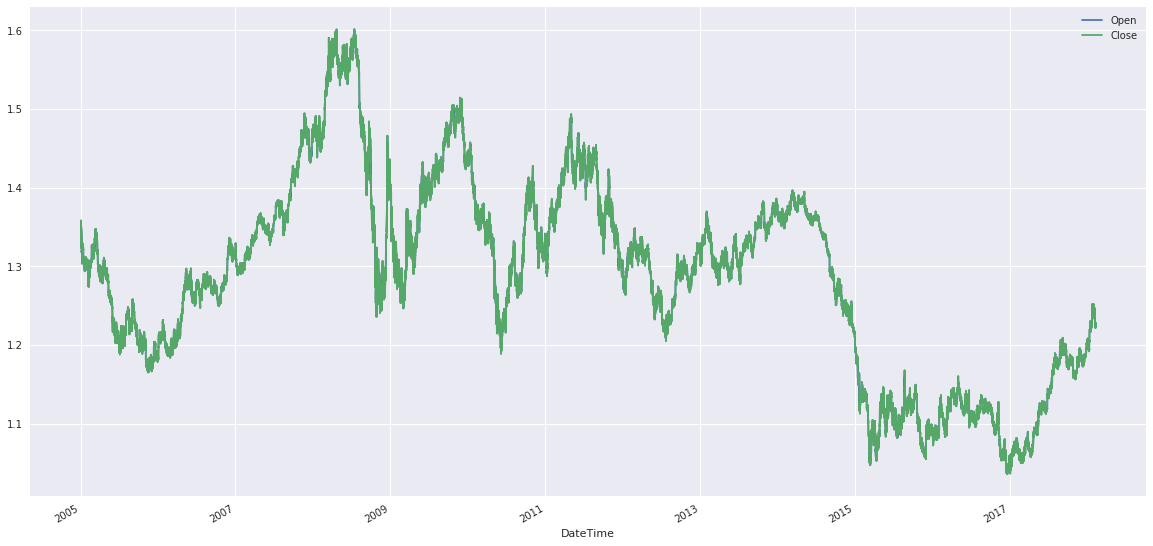

In [16]:
# plt.plot(range(len(data)) , data.iloc[: , 1])
data.plot(x='DateTime', y=['Open', 'Close'])

open and close price seem to be so close , so we would need one of them.

In [17]:
data = data.iloc[:, [0,2]]
data = data.rename(columns={'Close': 'Value'})

# Hyper Parameters

In [51]:
P = 10     # how many points to use for calulations
F = 20     # gap between last point and start range of measuring outcome of pattern

# calculate diffrence in default length 

*** this difference is kind of normalized in the whole project and it's gonna be used anywhere difference measurement needed***

In [52]:
def percent_change(start_p, current_p):
    try:
        x = ((current_p - start_p) / abs(start_p)) * 100
        if x == 0:
            return 1e-10
        else:
            return x
    except Exception as e:
        return 1e-10

In [53]:
percent_change(data.iloc[0,1] , data.iloc[1,1])

0.05162241887905036

*** pattern finder ***

In [114]:
def pattern_finder(data):
    for y in trange(P+1, x):
        tmp_pattern = []
        for i in range(P-1, -1, -1):
            tmp_pattern.append(percent_change(data.Value[y-P], data.Value[y-i]))

        current_point = data.Value[y]
        outcome_range = data.Value[y+F : y+P+F]
        try:
            avrage_outcome = outcome_range.mean()
        except Exception as e:
            print(e)
            avrage_outcome = 1e-10

        future_outcome = percent_change(current_point, avrage_outcome)

        pattern_ar.append(tmp_pattern)
        performance_ar.append(future_outcome)


    #     print('current :', current_point)
    #     print('outcome :', avrage_outcome)
    #     print('percent change outcome :', future_outcome, '%')
    #     print('_______')
    #     print(tmp_pattern)
    #     break

In [ ]:
x = len(data) - (P+F)
data_for_pool = []

for d in np.array(data.Value)[:-(P+F)]:
    data_for_pool.append()

y = P + 1
pattern_ar = []
performance_ar = []

ppool = mlp.Pool(processes=os.cpu_count())
ppool.map(pattern_finder, data_for_pool)

pattern_ar = np.array(pattern_ar)
performance_ar = np.array(performance_ar)

In [56]:
t = 35566
print(performance_ar[t])
print(pattern_ar[t])

0.36020935002475524
[-0.00705985 -0.11295765 -0.06212671 -0.15531678 -0.13272524 -0.19485195
 -0.22732728 -0.21885546 -0.24003502 -0.18073225]


In [57]:
len(performance_ar[performance_ar > 0])

83987

*** current pattern ***

In [58]:
current_pattern = []
for i in range(-P, 0):
    current_pattern.append(percent_change(data.Value.iloc[-P-1], data.Value.iloc[i]))
#     print(i, data.Value.iloc[i])

current_pattern = np.array(current_pattern)
print(current_pattern)

[-0.03353536 -0.09815228 -0.08915499  0.02453807  0.0229022   0.04335059
  0.06461692  0.07279628  0.1513181   0.20693773]


*** current pattern recognition ***

In [61]:
sim_pat_inx = []
for p in trange(len(pattern_ar)):
    sim = []
    for i in range(P):
        sim.append(100 - abs(percent_change(current_pattern[i], pattern_ar[p][i])))
    sim = np.array(sim)
    # max of how sim = 100
    how_sim = sim.mean()
    
#     print(sim)
#     print(how_sim)
    
    if how_sim >= 60:
        sim_pat_inx.append([p, how_sim])
print(len(sim_pat_inx), 'similar pattern found!')
print(sim_pat_inx)

100%|██████████| 166931/166931 [00:04<00:00, 33741.03it/s]

30 similar pattern found!
[[1641, 62.5862940924579], [1755, 61.593430354946705], [9539, 69.01206847855745], [23097, 61.03590348977472], [23420, 66.6954662837568], [24104, 60.4648729046222], [25659, 60.69462958579758], [31146, 61.54494096626163], [34573, 60.86678099366172], [37426, 62.44065733591365], [37714, 61.50409414638152], [38157, 60.024052660603694], [39400, 60.10395121679727], [43225, 62.94340344248801], [43624, 60.718372460652446], [61923, 64.66062308980742], [62374, 60.86770761787864], [66336, 62.22218669463755], [93033, 61.15265677688349], [97155, 63.3325395379289], [97441, 61.3101195459725], [100361, 67.57416645851733], [102639, 69.71707029300562], [105277, 63.57214297815072], [116179, 63.032993943129384], [124900, 63.315129965571046], [128207, 60.14823422643296], [153936, 74.71104917787497], [160588, 63.04938751274665], [161275, 67.36747093535922]]


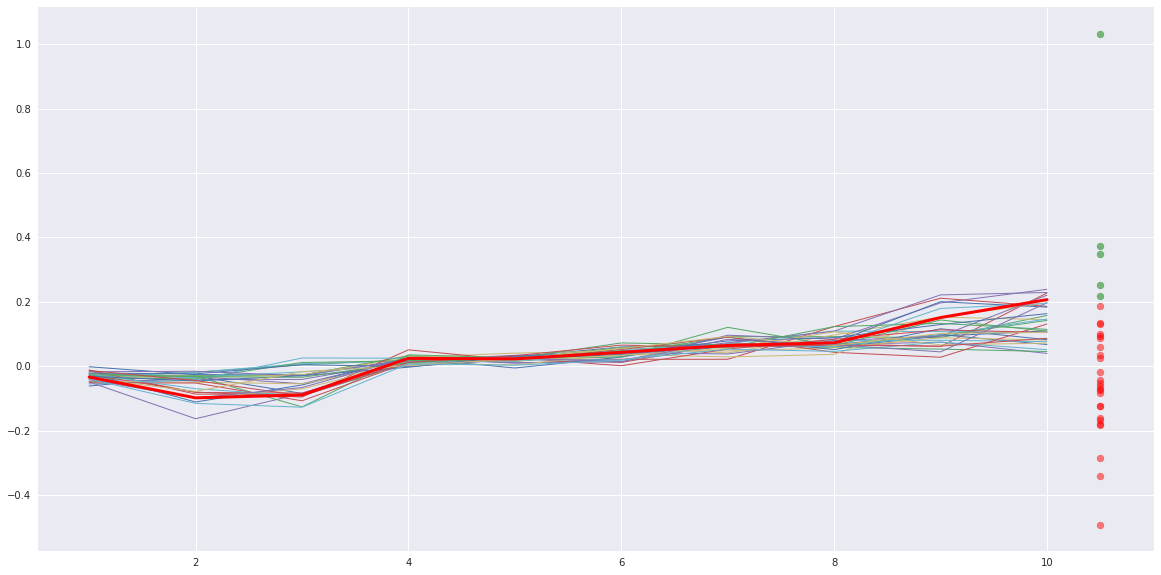

In [62]:
for i in range(len(sim_pat_inx)):
    plt.plot(range(1,P+1), pattern_ar[sim_pat_inx[i][0]], linewidth=1)
    
    tmp_performance = performance_ar[sim_pat_inx[i][0]]
    # if statement is because if future performance is upper than current patterns' change line
    if tmp_performance > current_pattern[-1]:
        pcolor = 'green'
    else:
        pcolor = 'red'
    plt.scatter(P+.5, performance_ar[sim_pat_inx[i][0]], c=pcolor, alpha=0.5)
plt.plot(range(1,P+1), current_pattern, c='red', linewidth=3)
plt.show()